# <center> TP - Text-Mining <center/>

** Before you begin this notebook, please make sure that you have the data folder + that you are running this notebook from your workspace **

_Now let's practice and use some text-mining techniques!_
<br/>
<br/> In this notebook we will study a mail dataset.
Our final goal is to have some insights about the different subjects that appear in mailboxes. Among other problems, one big issue is that these mailboxes are poluted with a lot of spams.

> The sequence we propose :
- First you'll work on pre-processing the content of the mails
- Then you will try to detect whether a mail is a spam or not through a supervized learning algorithm
- Finally, once you've trained an algorithm to detect spams, you will try to identify the main topics in the remaining non-spam mails

## The data

Data are separated in six parts, each containing around 5000 mails.
<br/> Each of these data chunks are separated in two parts : 
>- hams : that is to say non-spam mails
- spams : containing advertisement or unrelevant content

***
***

## 0. Imports

In [7]:
#Import usefull package
import os
import re
import string
import random
import numpy as np
import pandas as pd
from collections import Counter

#Import nltk packages to manipulate text
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.metrics import ConfusionMatrix
from nltk.stem.snowball import SnowballStemmer

from nltk import word_tokenize, WordNetLemmatizer, PorterStemmer
from nltk import NaiveBayesClassifier, classify
from nltk import pos_tag
from nltk import ngrams
#***
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

from nltk import word_tokenize,sent_tokenize

# Let's add a path containing some useful nltk data
nltk.data.path += ['/mnt/share/nltk_data']

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

from functools import reduce
from wordcloud import WordCloud

# scikit-learn packages
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import sklearn.metrics

# word2vec
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /Users/sebila/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sebila/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sebila/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sebila/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
# If you unzipped the data somewhere else, modify the variable hereunder
path_data  = "./enron1"

# I. Data ingestion

In [9]:
# Nothing to understand
def read_mails(folder):
    """
    Reads all the mails contained in a folder and gathers them in a list
    
    Args :
        folder (str) : path to the folder containing mails
        
    Returns :
        mails_list (list) : a list containing mails contents
    """
    
    mails_list = []
    files_list = os.listdir(folder)
    for file_name in files_list:
        file_content = open(folder + file_name, 'r', encoding='latin1')
        mails_list.append(file_content.read())
    file_content.close()
    return mails_list

## A. Load data

Data are separated in six parts, each containing around 5000 mails.
<br/> Each of these data chunks are separated in two parts : ham and spam
<br/>Let's load the first data chunk

In [12]:
spams = []
hams = []
for folder in os.listdir(path_data):
    if not folder.startswith('.') and folder != 'Summary.txt' :
        # Load corre spams
        spams.extend(read_mails(path_data +  '/' + folder + '/'))
        # Load corresponding hams
        hams.extend(read_mails(path_data +  '/' + folder +'/'))

In [17]:
hams_df = pd.read_csv('enron1/hams.csv')
spams_df = pd.read_csv('enron1/spams.csv')

In [18]:
hams[0]

"Subject: what up , , your cam babe\nwhat are you looking for ?\nif your looking for a companion for friendship , love , a date , or just good ole '\nfashioned * * * * * * , then try our brand new site ; it was developed and created\nto help anyone find what they ' re looking for . a quick bio form and you ' re\non the road to satisfaction in every sense of the word . . . . no matter what\nthat may be !\ntry it out and youll be amazed .\nhave a terrific time this evening\ncopy and pa ste the add . ress you see on the line below into your browser to come to the site .\nhttp : / / www . meganbang . biz / bld / acc /\nno more plz\nhttp : / / www . naturalgolden . com / retract /\ncounterattack aitken step preemptive shoehorn scaup . electrocardiograph movie honeycomb . monster war brandywine pietism byrne catatonia . encomia lookup intervenor skeleton turn catfish .\n"

In [19]:
spams = spams_df.text.to_list()

In [20]:
hams_df.count

<bound method DataFrame.count of       type                                               text
0      ham  Subject: ena sales on hpl just to update you o...
1      ham  Subject: 98 - 6736 & 98 - 9638 for 1997 ( ua 4...
2      ham  Subject: hpl nominations for december 28 , 199...
3      ham  Subject: revised nom - kcs resources daren , i...
4      ham  Subject: new production - sitara deals needed ...
...    ...                                                ...
16540  ham  Subject: uo mba visitors ( sorry for the late ...
16541  ham  Subject: colstrip cut 8 / 01 / 01 to whom this...
16542  ham  Subject: start date : 12 / 29 / 01 ; hourahead...
16543  ham  Subject: schedule crawler : hourahead failure ...
16544  ham  Subject: schedule crawler : hourahead failure ...

[16545 rows x 2 columns]>

## B. Split data for spam detection learning

We now split the data between train and test (proportion 80%/20%)

>**reminder**
<br/>
- Training set : data on which we are going to learn what is a spam and what is a ham
- Testing set : data that we will keep isolated, and on which we will test the algorithm. the model will never have seen these data when working on it

In [21]:
# TODO : Split data into train & test using train_test_split function
train_hams, test_hams = train_test_split(hams_df.text.to_list(), train_size=0.8, test_size=0.2, shuffle=False)
train_spams, test_spams = train_test_split(spams_df.text.to_list(), train_size=0.8, test_size=0.2, shuffle=False)

In [22]:
train_hams.count

<function list.count(value, /)>

Add its label to each mail

In [23]:
train_set = [(mail,'spam','train') for mail in train_spams] + [(mail,'ham','train') for mail in train_hams]
print('Train set size = ' + str(len(train_set)) + ' emails')

test_set = [(mail,'spam','test') for mail in test_spams] + [(mail,'ham','test') for mail in test_hams]
print('Test set size = ' + str(len(test_set)) + ' emails')

all_mails = train_set+test_set
random.shuffle(all_mails)

Train set size = 26972 emails
Test set size = 6744 emails


# II. Preprocessing

## A. Preprocessing one email

Display one email content

In [24]:
#Get one spam-email
single_email = train_set[0][0]
print('this mail is a : ' + str(train_set[3][1])+'\n')
print(single_email)

this mail is a : spam

Subject: what up , , your cam babe what are you looking for ? if your looking for a companion for friendship , love , a date , or just good ole ' fashioned * * * * * * , then try our brand new site ; it was developed and created to help anyone find what they ' re looking for . a quick bio form and you ' re on the road to satisfaction in every sense of the word . . . . no matter what that may be ! try it out and youll be amazed . have a terrific time this evening copy and pa ste the add . ress you see on the line below into your browser to come to the site . http : / / www . meganbang . biz / bld / acc / no more plz http : / / www . naturalgolden . com / retract / counterattack aitken step preemptive shoehorn scaup . electrocardiograph movie honeycomb . monster war brandywine pietism byrne catatonia . encomia lookup intervenor skeleton turn catfish . 


### Lower verbatim

Lower the content of the previously displayed mail

In [25]:
#TODO : lower case the email & print it
lower_mail = single_email.lower()
print(lower_mail)

subject: what up , , your cam babe what are you looking for ? if your looking for a companion for friendship , love , a date , or just good ole ' fashioned * * * * * * , then try our brand new site ; it was developed and created to help anyone find what they ' re looking for . a quick bio form and you ' re on the road to satisfaction in every sense of the word . . . . no matter what that may be ! try it out and youll be amazed . have a terrific time this evening copy and pa ste the add . ress you see on the line below into your browser to come to the site . http : / / www . meganbang . biz / bld / acc / no more plz http : / / www . naturalgolden . com / retract / counterattack aitken step preemptive shoehorn scaup . electrocardiograph movie honeycomb . monster war brandywine pietism byrne catatonia . encomia lookup intervenor skeleton turn catfish . 


### Tokenization

Here we are using a word tokenizer to divide the sentence into tokens

In [26]:
#TODO : tokenize your email and print it
tokenized_mail = word_tokenize(lower_mail)
print(tokenized_mail[0:100])

['subject', ':', 'what', 'up', ',', ',', 'your', 'cam', 'babe', 'what', 'are', 'you', 'looking', 'for', '?', 'if', 'your', 'looking', 'for', 'a', 'companion', 'for', 'friendship', ',', 'love', ',', 'a', 'date', ',', 'or', 'just', 'good', 'ole', "'", 'fashioned', '*', '*', '*', '*', '*', '*', ',', 'then', 'try', 'our', 'brand', 'new', 'site', ';', 'it', 'was', 'developed', 'and', 'created', 'to', 'help', 'anyone', 'find', 'what', 'they', "'", 're', 'looking', 'for', '.', 'a', 'quick', 'bio', 'form', 'and', 'you', "'", 're', 'on', 'the', 'road', 'to', 'satisfaction', 'in', 'every', 'sense', 'of', 'the', 'word', '.', '.', '.', '.', 'no', 'matter', 'what', 'that', 'may', 'be', '!', 'try', 'it', 'out', 'and', 'youll']


In [27]:
#TODO : create bigrams of your email & print it
bigrams = [bigram for bigram in ngrams(tokenized_mail,2)]
bigrams

[('subject', ':'),
 (':', 'what'),
 ('what', 'up'),
 ('up', ','),
 (',', ','),
 (',', 'your'),
 ('your', 'cam'),
 ('cam', 'babe'),
 ('babe', 'what'),
 ('what', 'are'),
 ('are', 'you'),
 ('you', 'looking'),
 ('looking', 'for'),
 ('for', '?'),
 ('?', 'if'),
 ('if', 'your'),
 ('your', 'looking'),
 ('looking', 'for'),
 ('for', 'a'),
 ('a', 'companion'),
 ('companion', 'for'),
 ('for', 'friendship'),
 ('friendship', ','),
 (',', 'love'),
 ('love', ','),
 (',', 'a'),
 ('a', 'date'),
 ('date', ','),
 (',', 'or'),
 ('or', 'just'),
 ('just', 'good'),
 ('good', 'ole'),
 ('ole', "'"),
 ("'", 'fashioned'),
 ('fashioned', '*'),
 ('*', '*'),
 ('*', '*'),
 ('*', '*'),
 ('*', '*'),
 ('*', '*'),
 ('*', ','),
 (',', 'then'),
 ('then', 'try'),
 ('try', 'our'),
 ('our', 'brand'),
 ('brand', 'new'),
 ('new', 'site'),
 ('site', ';'),
 (';', 'it'),
 ('it', 'was'),
 ('was', 'developed'),
 ('developed', 'and'),
 ('and', 'created'),
 ('created', 'to'),
 ('to', 'help'),
 ('help', 'anyone'),
 ('anyone', 'find'),


In [28]:
#TODO : create trigrams of your email & print it
trigrams = [trigram for trigram in ngrams(tokenized_mail,3)]
trigrams

[('subject', ':', 'what'),
 (':', 'what', 'up'),
 ('what', 'up', ','),
 ('up', ',', ','),
 (',', ',', 'your'),
 (',', 'your', 'cam'),
 ('your', 'cam', 'babe'),
 ('cam', 'babe', 'what'),
 ('babe', 'what', 'are'),
 ('what', 'are', 'you'),
 ('are', 'you', 'looking'),
 ('you', 'looking', 'for'),
 ('looking', 'for', '?'),
 ('for', '?', 'if'),
 ('?', 'if', 'your'),
 ('if', 'your', 'looking'),
 ('your', 'looking', 'for'),
 ('looking', 'for', 'a'),
 ('for', 'a', 'companion'),
 ('a', 'companion', 'for'),
 ('companion', 'for', 'friendship'),
 ('for', 'friendship', ','),
 ('friendship', ',', 'love'),
 (',', 'love', ','),
 ('love', ',', 'a'),
 (',', 'a', 'date'),
 ('a', 'date', ','),
 ('date', ',', 'or'),
 (',', 'or', 'just'),
 ('or', 'just', 'good'),
 ('just', 'good', 'ole'),
 ('good', 'ole', "'"),
 ('ole', "'", 'fashioned'),
 ("'", 'fashioned', '*'),
 ('fashioned', '*', '*'),
 ('*', '*', '*'),
 ('*', '*', '*'),
 ('*', '*', '*'),
 ('*', '*', '*'),
 ('*', '*', ','),
 ('*', ',', 'then'),
 (',', 'th

### Lemmatize 

We want to lemmatize the verbatims

In [29]:
#TODO get lemmatizer
lemmatizer = WordNetLemmatizer()

In [30]:
#TODO print lemmatisation of "found" without POS
print('Lemmatisation without POS : found -> ' + lemmatizer.lemmatize('viewing'))
#TODO print lemmatisation of "found" with POS
print('Lemmatisation with POS : found -> ' + lemmatizer.lemmatize('viewing','v'))

Lemmatisation without POS : found -> viewing
Lemmatisation with POS : found -> view


One little subtelty : Lemmatizing efficiently requires to pos_tag the words to know their grammatical nature

### Let's pos_tag the tokens

In [31]:
#TODO pos_tag your tokenized email & print it
pos_tagged_mail = nltk.pos_tag(tokenized_mail)
pos_tagged_mail

[('subject', 'NN'),
 (':', ':'),
 ('what', 'WP'),
 ('up', 'IN'),
 (',', ','),
 (',', ','),
 ('your', 'PRP$'),
 ('cam', 'NN'),
 ('babe', 'IN'),
 ('what', 'WP'),
 ('are', 'VBP'),
 ('you', 'PRP'),
 ('looking', 'VBG'),
 ('for', 'IN'),
 ('?', '.'),
 ('if', 'IN'),
 ('your', 'PRP$'),
 ('looking', 'VBG'),
 ('for', 'IN'),
 ('a', 'DT'),
 ('companion', 'NN'),
 ('for', 'IN'),
 ('friendship', 'NN'),
 (',', ','),
 ('love', 'NN'),
 (',', ','),
 ('a', 'DT'),
 ('date', 'NN'),
 (',', ','),
 ('or', 'CC'),
 ('just', 'RB'),
 ('good', 'JJ'),
 ('ole', 'NN'),
 ("'", 'POS'),
 ('fashioned', 'VBN'),
 ('*', 'NNP'),
 ('*', 'NNP'),
 ('*', 'NNP'),
 ('*', 'NNP'),
 ('*', 'NNP'),
 ('*', 'NNP'),
 (',', ','),
 ('then', 'RB'),
 ('try', 'VB'),
 ('our', 'PRP$'),
 ('brand', 'NN'),
 ('new', 'JJ'),
 ('site', 'NN'),
 (';', ':'),
 ('it', 'PRP'),
 ('was', 'VBD'),
 ('developed', 'VBN'),
 ('and', 'CC'),
 ('created', 'VBN'),
 ('to', 'TO'),
 ('help', 'VB'),
 ('anyone', 'NN'),
 ('find', 'VB'),
 ('what', 'WP'),
 ('they', 'PRP'),
 ("'",

In [32]:
# Nothing to understand
def get_wordnet_pos(pos_tag):
    """
    Modifies pos_tag to get a more general nature of word
    """
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return 'v'
        #return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

### Lemmatizer 

In [33]:
#TODO: Lemmatize your email without pos & print it
lemmatized_mail_no_pos = [lemmatizer.lemmatize(word[0]) for word in pos_tagged_mail]
print(lemmatized_mail_no_pos)

['subject', ':', 'what', 'up', ',', ',', 'your', 'cam', 'babe', 'what', 'are', 'you', 'looking', 'for', '?', 'if', 'your', 'looking', 'for', 'a', 'companion', 'for', 'friendship', ',', 'love', ',', 'a', 'date', ',', 'or', 'just', 'good', 'ole', "'", 'fashioned', '*', '*', '*', '*', '*', '*', ',', 'then', 'try', 'our', 'brand', 'new', 'site', ';', 'it', 'wa', 'developed', 'and', 'created', 'to', 'help', 'anyone', 'find', 'what', 'they', "'", 're', 'looking', 'for', '.', 'a', 'quick', 'bio', 'form', 'and', 'you', "'", 're', 'on', 'the', 'road', 'to', 'satisfaction', 'in', 'every', 'sense', 'of', 'the', 'word', '.', '.', '.', '.', 'no', 'matter', 'what', 'that', 'may', 'be', '!', 'try', 'it', 'out', 'and', 'youll', 'be', 'amazed', '.', 'have', 'a', 'terrific', 'time', 'this', 'evening', 'copy', 'and', 'pa', 'ste', 'the', 'add', '.', 'res', 'you', 'see', 'on', 'the', 'line', 'below', 'into', 'your', 'browser', 'to', 'come', 'to', 'the', 'site', '.', 'http', ':', '/', '/', 'www', '.', 'mega

In [34]:
##TODO: Lemmatize your email with pos & print it
lemmatized_mail = [lemmatizer.lemmatize(word[0],get_wordnet_pos(word[1])) for word in pos_tagged_mail]
print(lemmatized_mail)

['subject', ':', 'what', 'up', ',', ',', 'your', 'cam', 'babe', 'what', 'be', 'you', 'look', 'for', '?', 'if', 'your', 'look', 'for', 'a', 'companion', 'for', 'friendship', ',', 'love', ',', 'a', 'date', ',', 'or', 'just', 'good', 'ole', "'", 'fashion', '*', '*', '*', '*', '*', '*', ',', 'then', 'try', 'our', 'brand', 'new', 'site', ';', 'it', 'be', 'develop', 'and', 'create', 'to', 'help', 'anyone', 'find', 'what', 'they', "'", 're', 'look', 'for', '.', 'a', 'quick', 'bio', 'form', 'and', 'you', "'", 're', 'on', 'the', 'road', 'to', 'satisfaction', 'in', 'every', 'sense', 'of', 'the', 'word', '.', '.', '.', '.', 'no', 'matter', 'what', 'that', 'may', 'be', '!', 'try', 'it', 'out', 'and', 'youll', 'be', 'amaze', '.', 'have', 'a', 'terrific', 'time', 'this', 'evening', 'copy', 'and', 'pa', 'ste', 'the', 'add', '.', 'res', 'you', 'see', 'on', 'the', 'line', 'below', 'into', 'your', 'browser', 'to', 'come', 'to', 'the', 'site', '.', 'http', ':', '/', '/', 'www', '.', 'meganbang', '.', 'bi

In [35]:
#TODO: Did we deleted word between tokenization & lemmatization ?
print ('Length Lemmatized single email = ' + str(len(lemmatized_mail)) + ' words')
print ('Length Tokenized single email = ' + str(len(tokenized_mail)) + ' words')

Length Lemmatized single email = 186 words
Length Tokenized single email = 186 words


## Stemmer

In [36]:
stemmer = SnowballStemmer('english')
#TODO: stem your email
stemmed_email = [stemmer.stem(word) for word in tokenized_mail]
print(stemmed_email)

['subject', ':', 'what', 'up', ',', ',', 'your', 'cam', 'babe', 'what', 'are', 'you', 'look', 'for', '?', 'if', 'your', 'look', 'for', 'a', 'companion', 'for', 'friendship', ',', 'love', ',', 'a', 'date', ',', 'or', 'just', 'good', 'ole', "'", 'fashion', '*', '*', '*', '*', '*', '*', ',', 'then', 'tri', 'our', 'brand', 'new', 'site', ';', 'it', 'was', 'develop', 'and', 'creat', 'to', 'help', 'anyon', 'find', 'what', 'they', "'", 're', 'look', 'for', '.', 'a', 'quick', 'bio', 'form', 'and', 'you', "'", 're', 'on', 'the', 'road', 'to', 'satisfact', 'in', 'everi', 'sens', 'of', 'the', 'word', '.', '.', '.', '.', 'no', 'matter', 'what', 'that', 'may', 'be', '!', 'tri', 'it', 'out', 'and', 'youll', 'be', 'amaz', '.', 'have', 'a', 'terrif', 'time', 'this', 'even', 'copi', 'and', 'pa', 'ste', 'the', 'add', '.', 'ress', 'you', 'see', 'on', 'the', 'line', 'below', 'into', 'your', 'browser', 'to', 'come', 'to', 'the', 'site', '.', 'http', ':', '/', '/', 'www', '.', 'meganbang', '.', 'biz', '/', 

In [37]:
#TODO: print the length of your email
print ('Length stemmed single email = ' + str(len(stemmed_email)) + ' words')

Length stemmed single email = 186 words


### Stopwords

In [38]:
# Have a look at stopwords
stoplist = stopwords.words('english')
#TODO: print example of stop words
print('Example of stop words in english :')
print(stoplist)

Example of stop words in english :
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'on

In [39]:
#TODO: removing stopwords
mail_no_stopwords = [word for word in lemmatized_mail if word not in stoplist]
print ('Length single email with stopwords = ' + str(len(tokenized_mail)) + ' words')
print ('Length single email without stopwords = ' + str(len(mail_no_stopwords)) + ' words')

Length single email with stopwords = 186 words
Length single email without stopwords = 127 words


In [40]:
print(tokenized_mail)
print('---------------------------------')
print(mail_no_stopwords)

['subject', ':', 'what', 'up', ',', ',', 'your', 'cam', 'babe', 'what', 'are', 'you', 'looking', 'for', '?', 'if', 'your', 'looking', 'for', 'a', 'companion', 'for', 'friendship', ',', 'love', ',', 'a', 'date', ',', 'or', 'just', 'good', 'ole', "'", 'fashioned', '*', '*', '*', '*', '*', '*', ',', 'then', 'try', 'our', 'brand', 'new', 'site', ';', 'it', 'was', 'developed', 'and', 'created', 'to', 'help', 'anyone', 'find', 'what', 'they', "'", 're', 'looking', 'for', '.', 'a', 'quick', 'bio', 'form', 'and', 'you', "'", 're', 'on', 'the', 'road', 'to', 'satisfaction', 'in', 'every', 'sense', 'of', 'the', 'word', '.', '.', '.', '.', 'no', 'matter', 'what', 'that', 'may', 'be', '!', 'try', 'it', 'out', 'and', 'youll', 'be', 'amazed', '.', 'have', 'a', 'terrific', 'time', 'this', 'evening', 'copy', 'and', 'pa', 'ste', 'the', 'add', '.', 'ress', 'you', 'see', 'on', 'the', 'line', 'below', 'into', 'your', 'browser', 'to', 'come', 'to', 'the', 'site', '.', 'http', ':', '/', '/', 'www', '.', 'me

In [41]:
#TODO: add some relevant stopwords
stoplist += ['g']
stoplist += ['r']
stoplist += ['e']

In [42]:
#TODO: removing new stopwords
mail_no_stopwords = [word for word in lemmatized_mail if word not in stoplist]

In [43]:
print(tokenized_mail)
print('---------------------------------')
print(mail_no_stopwords)
print('---------------------------------')
print ('Length single email without stopwords = ' + str(len(mail_no_stopwords)) + ' words' )

['subject', ':', 'what', 'up', ',', ',', 'your', 'cam', 'babe', 'what', 'are', 'you', 'looking', 'for', '?', 'if', 'your', 'looking', 'for', 'a', 'companion', 'for', 'friendship', ',', 'love', ',', 'a', 'date', ',', 'or', 'just', 'good', 'ole', "'", 'fashioned', '*', '*', '*', '*', '*', '*', ',', 'then', 'try', 'our', 'brand', 'new', 'site', ';', 'it', 'was', 'developed', 'and', 'created', 'to', 'help', 'anyone', 'find', 'what', 'they', "'", 're', 'looking', 'for', '.', 'a', 'quick', 'bio', 'form', 'and', 'you', "'", 're', 'on', 'the', 'road', 'to', 'satisfaction', 'in', 'every', 'sense', 'of', 'the', 'word', '.', '.', '.', '.', 'no', 'matter', 'what', 'that', 'may', 'be', '!', 'try', 'it', 'out', 'and', 'youll', 'be', 'amazed', '.', 'have', 'a', 'terrific', 'time', 'this', 'evening', 'copy', 'and', 'pa', 'ste', 'the', 'add', '.', 'ress', 'you', 'see', 'on', 'the', 'line', 'below', 'into', 'your', 'browser', 'to', 'come', 'to', 'the', 'site', '.', 'http', ':', '/', '/', 'www', '.', 'me

### Punctuation

In [44]:
#TODO: create a punctuation list
stop_punctuation = [':', '(', ')', '/', '|', ',',
                    '.', '*', '#', '"', '&', '~',
                    '-', '_', '\\', '@','?','!','\'']

#TODO: removing punctuation & print it
mail_clean = [word for word in mail_no_stopwords if word not in stop_punctuation]

print(mail_clean)
print ('\nLength single email without stopwords = ' + str(len(mail_clean)) + ' words')

['subject', 'cam', 'babe', 'look', 'look', 'companion', 'friendship', 'love', 'date', 'good', 'ole', 'fashion', 'try', 'brand', 'new', 'site', ';', 'develop', 'create', 'help', 'anyone', 'find', 'look', 'quick', 'bio', 'form', 'road', 'satisfaction', 'every', 'sense', 'word', 'matter', 'may', 'try', 'youll', 'amaze', 'terrific', 'time', 'evening', 'copy', 'pa', 'ste', 'add', 'res', 'see', 'line', 'browser', 'come', 'site', 'http', 'www', 'meganbang', 'biz', 'bld', 'acc', 'plz', 'http', 'www', 'naturalgolden', 'com', 'retract', 'counterattack', 'aitken', 'step', 'preemptive', 'shoehorn', 'scaup', 'electrocardiograph', 'movie', 'honeycomb', 'monster', 'war', 'brandywine', 'pietism', 'byrne', 'catatonia', 'encomium', 'lookup', 'intervenor', 'skeleton', 'turn', 'catfish']

Length single email without stopwords = 82 words


## B. Preprocessing all emails

### Functions definition 

In [48]:
def preprocess(sentence):
    """
    Tokenizes, lowers, and stems
    """
    stemmer = SnowballStemmer('english')
    return [stemmer.stem(word.lower()) for word in word_tokenize(sentence)]

def get_features(text):
    return {word: True for word in preprocess(text) if word not in stoplist and word not in stop_punctuation}

def get_features_no_processing(text):
    return {word: True for word in word_tokenize(text)}

In [49]:
# extract the features
all_features = [(get_features(email), label, data_set) for (email, label,data_set) in all_mails]
print ('Collected ' + str(len(all_features)) + ' feature sets')

Collected 33716 feature sets


In [51]:
# extract the features without preprocessing
all_raw_features = [(get_features_no_processing(email), label, data_set) for (email, label,data_set) in all_mails]
print ('Collected ' + str(len(all_raw_features)) + ' feature sets')

Collected 33716 feature sets


## III. Vectorization

## TFIDF

In [53]:
#getting subject + content
def get_subject(text):
    return (text.split('\n', 1)[0]).split('Subject:', 1)[1]

def get_content(text):
    return text.split('\n', 1)[1]

In [65]:
# Let's consider the list of ham emails
ham_df = pd.DataFrame({'text': hams})
ham_df.head()

,text
0,"Subject: what up , , your cam babe\nwhat are y..."
1,Subject: want to make more money ?\norder conf...
2,Subject: food for thoughts\n[\njoin now - take...
3,Subject: miningnews . net newsletter - tuesday...
4,Subject: your pharmacy ta\nwould you want chea...


In [54]:
# Let's consider the list of ham emails
ham_df = pd.DataFrame({'text':hams})

#Extract subject & content
ham_df["subject"]=ham_df.text.apply(get_subject)
ham_df["content"]=ham_df.text.apply(get_content)

ham_df.head(3)

,text,subject,content
0,"Subject: what up , , your cam babe\nwhat are y...","what up , , your cam babe",what are you looking for ?\nif your looking fo...
1,Subject: want to make more money ?\norder conf...,want to make more money ?,order confirmation . your order should be ship...
2,Subject: food for thoughts\n[\njoin now - take...,food for thoughts,[\njoin now - take\na free tour ]\nclick here ...


In [55]:
# customize stopwords list
stoplist_bis = stoplist + ['enron','hou','ect','cc','thank','pleas','com','said','would','please','kaminski','subject']
stop_punctuation = [':', '(', ')', '/', '|', ',',
                    '.', '*', '#', '"', '&', '~',
                    '-', '_', '\\', '@','?','!']

In [56]:
#clean text
def clean_text(text):
    # Remove figures
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Tokenization
    words = text.lower().split()
    stemmer = SnowballStemmer('english')
    words = [stemmer.stem(w) for w in words if w not in stoplist and not w in stop_punctuation ]
    return ' '.join(words)

In [57]:
ham_df["clean_content"]=ham_df.content.apply(clean_text)
ham_df.head(3)

,text,subject,content,clean_content
0,"Subject: what up , , your cam babe\nwhat are y...","what up , , your cam babe",what are you looking for ?\nif your looking fo...,look look companion friendship love date good ...
1,Subject: want to make more money ?\norder conf...,want to make more money ?,order confirmation . your order should be ship...,order confirm order ship januari via fedex fed...
2,Subject: food for thoughts\n[\njoin now - take...,food for thoughts,[\njoin now - take\na free tour ]\nclick here ...,join take free tour click remov


In [64]:
tfidf = TfidfVectorizer(analyzer='word', stop_words=None, max_df=0.3, min_df=5)
tfidf_fit = tfidf.fit_transform(ham_df.clean_content)
feature = tfidf.get_feature_names()
feature

['aa',
 'aaron',
 'ab',
 'aba',
 'abacus',
 'abacustech',
 'abat',
 'abb',
 'abbot',
 'abbott',
 'abc',
 'abdomin',
 'abel',
 'abet',
 'abiiiti',
 'abil',
 'abl',
 'abnorm',
 'aboard',
 'abroad',
 'absenc',
 'absent',
 'absolut',
 'absorb',
 'abstract',
 'abund',
 'abus',
 'ac',
 'acceler',
 'accent',
 'accentu',
 'accept',
 'access',
 'accessori',
 'accommod',
 'accomod',
 'accompani',
 'accomplish',
 'accord',
 'account',
 'accredit',
 'accret',
 'accru',
 'accrual',
 'acctg',
 'accumui',
 'accumul',
 'accur',
 'accuraci',
 'accus',
 'ach',
 'acheiv',
 'achiev',
 'acid',
 'acidul',
 'acknowledg',
 'acock',
 'acquir',
 'acquisit',
 'acr',
 'acrobat',
 'across',
 'acryl',
 'act',
 'action',
 'activ',
 'acton',
 'actua',
 'actual',
 'acyclovir',
 'ad',
 'adam',
 'adapt',
 'add',
 'addit',
 'additiona',
 'address',
 'addresse',
 'adequ',
 'adio',
 'adipex',
 'adipren',
 'adjust',
 'admin',
 'administ',
 'administr',
 'admir',
 'admit',
 'adob',
 'adolesc',
 'adoni',
 'adopt',
 'adult',
 

### Idea to go further on content analysis

Use a Kmeans algorithm to identify cluster based on TFIDF results

In [60]:
#TODO: define a KMeans classifier + fit the tfidf_fit
#classifier N = 4
clf = KMeans(n_clusters=4, max_iter=50)
labels = clf.fit_predict(tfidf_fit)

In [61]:
ham_df['cluster'] = labels

In [62]:
#to show in 2D
tfidf_fit_2d = tfidf_fit.todense()
pca = PCA(n_components=2).fit(tfidf_fit_2d)
datapoint = pca.transform(tfidf_fit_2d)

In [67]:
pca

PCA(n_components=2)

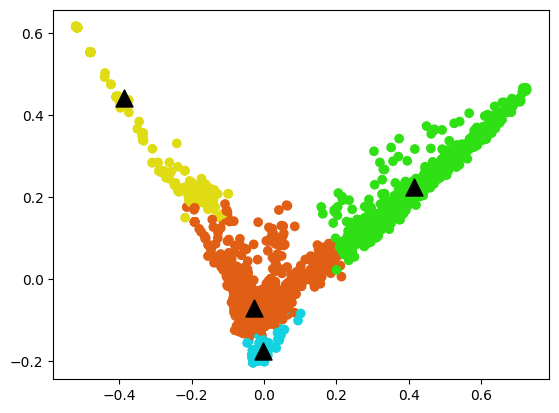

In [63]:
label = ["#e05f14", "#e0dc14", "#2fe014", "#14d2e0"]
color = [label[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = clf.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

## Let's try to use word2vec

Useful link for Word2Vec API : https://radimrehurek.com/gensim/models/word2vec.html

In [69]:
#TODO : create a Word2vect space using all ham emails
content = Word2Vec([word_tokenize(ham) for ham in hams], window=5)

In [70]:
#TODO: find most similar word for hello
content.wv.most_similar('enron')

[('tom', 0.7166849970817566),
 ('pat', 0.7074065208435059),
 ('clynes', 0.6933135390281677),
 ('acton', 0.6919487118721008),
 ('chokshi', 0.6599977612495422),
 ('griffin', 0.6444367170333862),
 ('mary', 0.6436408758163452),
 ('flavin', 0.6404175162315369),
 ('corp', 0.6365158557891846),
 ('rebecca', 0.6364901065826416)]

In [71]:
#TODO: find most similar word for hpay
content.wv.most_similar('pay')

[('stay', 0.763365626335144),
 ('take', 0.7462420463562012),
 ('share', 0.7446545958518982),
 ('pull', 0.7363286018371582),
 ('receive', 0.7302340269088745),
 ('buy', 0.7289506196975708),
 ('money', 0.7252339720726013),
 ('sell', 0.717952311038971),
 ('charge', 0.7160916924476624),
 ('bring', 0.7144665718078613)]

In [72]:
#TODO: find most similar word for a punctuation
content.wv.most_similar('.')

[('crodrig', 0.4768805503845215),
 ('moosq', 0.45713478326797485),
 ('again', 0.4467971920967102),
 ('correct', 0.433024138212204),
 ('amazon', 0.4320002794265747),
 ('745', 0.43051308393478394),
 ('reached', 0.42132657766342163),
 ('notice', 0.4181802570819855),
 ('also', 0.4153989255428314),
 ('received', 0.4153888523578644)]

In [73]:
#TODO: show the vector of one word
content.wv['king']

array([-2.15994924e-01,  4.43166643e-01, -2.10246488e-01, -3.76376271e-01,
        1.39238283e-01, -5.46150133e-02,  1.50111467e-01,  4.00714695e-01,
        9.40237567e-02,  2.26727556e-02, -6.06109321e-01, -5.25927722e-01,
        1.04698360e-01, -1.13424346e-01, -2.81241208e-01, -2.98000693e-01,
       -2.61494070e-01, -2.70248711e-01,  2.98737168e-01, -7.93635428e-01,
        2.28365153e-01,  3.24696720e-01,  6.43690377e-02,  1.58306018e-01,
       -3.95633847e-01, -1.02505289e-01, -3.92381139e-02, -1.64815649e-01,
        1.92602780e-02, -1.70934156e-01,  3.42947547e-04,  2.78160006e-01,
        2.16530040e-01, -2.83714145e-01, -3.31760556e-01,  2.92641640e-01,
        3.35729778e-01, -2.73187816e-01, -2.18580365e-01, -1.54454648e-01,
       -2.48740703e-01, -1.20649412e-01,  1.35743275e-01,  1.45751715e-01,
        3.28219801e-01,  2.72831857e-01, -5.59333079e-02, -2.78785944e-01,
       -9.29147825e-02, -5.83837330e-02, -4.26175557e-02,  8.54104906e-02,
        4.01736528e-01,  

In [74]:
#TODO: find the word which doesn't match in {pay, money, cash, start}
content.wv.doesnt_match('pay money cash start'.split(' '))

'cash'

## How to characterize each cluster

In this part, we will define two helpful functions to describe the clusters we've found
<br/> We will print a wordcloud containing the most frequent words

In [ ]:
# word occurence dictionary
def word_count(A,threshold):
    """
    This function computes occurrences of words in A
    But keeps only words with frequency above threshold
    
    Args :
        A (list): list of words in the verbatim
        threshold (float) : threshold beneath which the word is not kept (in % of max frequency)
        
    Returns :
        d_select (dict) : frequency dict with a subset of words
    """
    print(len(A))
    d_all = Counter(A)
    max_freq = max(d_all.values())
    d_select = {k:v for (k,v) in d_all.items() if v>threshold*max_freq}
    return d_select

In [ ]:
def plot_wordcloud_for_cluster(df_in, cluster_id, threshold):
    """
    This function computes word frequencies and plots a wordcloud
    for all the verbatims contained in a given cluster
    
    Args :
        df_in (pandas.DataFrame) : input dataframe containing verbatims and their cluster
        cluster_id : identification number of the studied cluster
        threshold : frequency threshold to keep a word
    
    Returns :
        d_frequency : frequency dict
    """
    
    # filter verbatims according to cluster
    df_in_cluster = df_in[df_in['cluster']==cluster_id]
    
    # Compute word frequency
    wc = word_count(' '.join(df_in_cluster['clean_content']).split(),threshold)
    wordcloud = WordCloud(background_color = 'white').fit_words(wc)

    # Generate plot
    plt.title("Most frequent words in cluster " + str(cluster_id))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
    return wc

20112


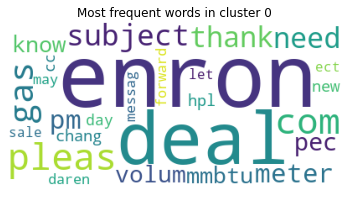

In [ ]:
#TODO: create a wordcloud for each cluster
wc = plot_wordcloud_for_cluster(ham_df,0,0.22)

In [ ]:
wc = plot_wordcloud_for_cluster(spams_df,0,0.22)

KeyError: ignored

## IV. Classification

In [ ]:
# Try to understand
# Definition of the classification function using Naive Bayes model
def train(features):
    """
    Trains NBC on training set 
    
    Args :
        features (dict) : dictionnary giving words present in the verbatim
        
    Returns :
        train_set : list of verbatims in the train set
        test_set : list of verbatims in the test set
        classifier : trained NBC model
    """
    # initialize training set and test set
    train_set = [(feature[0],feature[1]) for feature in features if feature[2]=='train']
    test_set = [(feature[0],feature[1]) for feature in features if feature[2]=='test']
    print ('Training set size = ' + str(len(train_set)) + ' emails')
    print ('Test set size = ' + str(len(test_set)) + ' emails')
    
    # train the classifier
    classifier = NaiveBayesClassifier.train(train_set)
    return train_set, test_set, classifier

In [ ]:
# Try to understand
def most_informative_features_by_label(classifier, label, n=50):
    """
    Returns features and their importance
    """
    cpdist = classifier._feature_probdist
    feature_list = []
    for (fname, fval) in classifier.most_informative_features(n):
        def labelprob(l):
            return cpdist[l, fname].prob(fval)
        labels = sorted([l for l in classifier._labels if fval in cpdist[l, fname].samples()], 
                        key=labelprob)
        if labels[-1] == label:
            feature_list.append(fname)
    return feature_list

In [ ]:
def evaluate(train_set, test_set, classifier):
    """
    Checks how the classifier performs on the training and test sets
    """
    print ('Accuracy on the training set = ' + str(classify.accuracy(classifier, train_set)))
    print ('Accuracy of the test set = ' + str(classify.accuracy(classifier, test_set)))
    return

### Let's try a random guess :

We look at the distribution ham/spam in the training set, and we randomly chose the label of each mail in the test set with the witnessed distribution

In [ ]:
#TODO: look at hams/spams distribution
labels_train = [elem[1] for elem in train_set]
count = Counter([elem[1] for elem in train_set])
ham_prop = 100*count['ham']/(count['ham']+count['spam'])
print('we have ' + str(ham_prop) + ' % of ham')

we have 49.07311285777844 % of ham


In [ ]:
#TODO: create a random classifier with this proportion
labels_random = [random.choice(labels_train) for i in range(len(test_set))]
correct_label = [elem[1] for elem in test_set]
print('our accuracy :')
reduce(lambda x,y : x+y,
       [1 if correct_label[i]==labels_random[i] else 0 for i in range(len(test_set))],
       0)/len(test_set)

our accuracy :


0.4980723606168446

### Let's try a Naive Bayes Classifier with no preprocessing

In [ ]:
#TODO: train the Naive Bayes classifier for all_raw_features
train_set, test_set, classifier_raw = train(all_raw_features)

Training set size = 26972 emails
Test set size = 6744 emails


In [ ]:
#TODO: show most informative features
classifier_raw.show_most_informative_features(10)

Most Informative Features
                   enron = True              ham : spam   =   4471.1 : 1.0
                     hpl = True              ham : spam   =    485.5 : 1.0
                     php = True             spam : ham    =    483.4 : 1.0
                     xls = True              ham : spam   =    400.2 : 1.0
                    meds = True             spam : ham    =    307.4 : 1.0
                   corel = True             spam : ham    =    265.6 : 1.0
                        = True              ham : spam   =    256.3 : 1.0
             derivatives = True              ham : spam   =    255.6 : 1.0
              macromedia = True             spam : ham    =    241.9 : 1.0
                     ect = True              ham : spam   =    240.7 : 1.0


In [ ]:
#TODO: evaluate accuracy of the model
evaluate(train_set, test_set, classifier_raw)

Accuracy on the training set = 0.986801127094765
Accuracy of the test set = 0.9730130486358244


### Let's train the model with a preprocessing

In [ ]:
#TODO: train the Naive Bayes classifier for all_features
train_set, test_set, classifier = train(all_features)

Training set size = 26972 emails
Test set size = 6744 emails


In [ ]:
#TODO: show most informative features
classifier.show_most_informative_features(10)

Most Informative Features
                   enron = True              ham : spam   =   4471.1 : 1.0
                     hpl = True              ham : spam   =    485.5 : 1.0
                     php = True             spam : ham    =    483.4 : 1.0
                     xls = True              ham : spam   =    400.2 : 1.0
                   corel = True             spam : ham    =    268.2 : 1.0
                        = True              ham : spam   =    256.3 : 1.0
              macromedia = True             spam : ham    =    241.9 : 1.0
                   louis = True              ham : spam   =    238.1 : 1.0
                     eol = True              ham : spam   =    214.8 : 1.0
                     713 = True              ham : spam   =    207.9 : 1.0


In [ ]:
#TODO: evaluate accuracy of the model
evaluate(train_set, test_set, classifier)

Accuracy on the training set = 0.9927702802906718
Accuracy of the test set = 0.9875444839857651


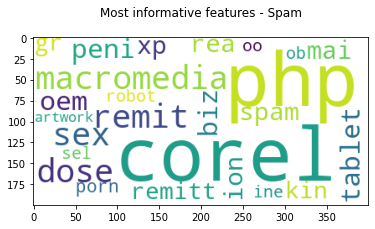

In [ ]:
#TODO: create a wordcloud with most informative features for spam
wordcloud_spam = WordCloud(background_color='white').generate(' '.join(most_informative_features_by_label(classifier,'spam')))
plt.imshow(wordcloud_spam)
plt.title("Most informative features - Spam\n")
plt.axis()
plt.show()

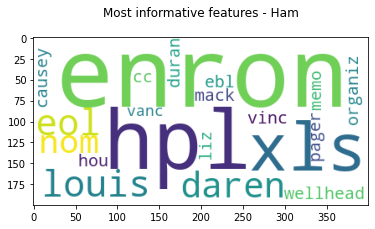

In [ ]:
#TODO: create a wordcloud with most informative features for ham
wordcloud_ham = WordCloud(background_color='white').generate(' '.join(most_informative_features_by_label(classifier,'ham')))
plt.imshow(wordcloud_ham)
plt.title("Most informative features - Ham\n")
plt.axis()
plt.show()

### Other metrics to explore

In [ ]:
# variables

test_features = [feature[0] for feature in test_set]
test_label = [feature[1] for feature in test_set]
prediction = classifier.classify_many(test_features)

#TODO: show confusion matrix on test set ++ precision on spam prediction on test set + recall on spam prediction on test set

cm = 
print("Confusion Matrix on test set" )
print(cm)
print("Precision on spam prediction on test set = " 
      + str(sklearn.metrics.precision_score(test_label,prediction,pos_label='ham')))
print("Recall on spam prediction on test set = " 
      + str(sklearn.metrics.recall_score(test_label,prediction,pos_label='ham')))